In [27]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline
import matplotlib.pyplot as plt
import definitions
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Cleaning & Pre-processing

Portfolio Data Cleaning

In [28]:
##Converting duration days to hours for parity with time column in trancript
portfolio['duration_h'] = portfolio['duration']*24
portfolio['offer_id'] = portfolio.index+1


In [29]:
# To normalize the amounts in rewards and difficulty columns, Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
offer_amounts_col = ['difficulty','reward']

#features_log_minmax_transform
portfolio[offer_amounts_col] = scaler.fit_transform(portfolio[offer_amounts_col])

portfolio.head()

,channels,difficulty,duration,id,offer_type,reward,duration_h,offer_id
0,"[email, mobile, social]",0.50,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,1.0,168,1
1,"[web, email, mobile, social]",0.50,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,1.0,120,2
2,"[web, email, mobile]",0.00,4,3f207df678b143eea3cee63160fa8bed,informational,0.0,96,3
3,"[web, email, mobile]",0.25,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,0.5,168,4
4,"[web, email]",1.00,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,0.5,240,5


Profile Data Cleaning

In [30]:
##It was found that age=118 was a placeholder for people whose information was not available
profile = profile[profile['age']!=118].reset_index(drop=True)

In [31]:
##Converting string to datetime and capturing the year
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'].astype(str), format='%Y%m%d')
profile['member_year'] = profile['became_member_on'].dt.year

In [33]:
profile['person_id'] = profile.index+1

In [32]:
profile['age_group'] = pd.cut(profile['age'], bins=[17, 22, 35, 60, 103],labels=['teenager', 'young-adult', 'adult', 'elderly'])

In [68]:
profile.head()

,age,became_member_on,gender,id,income,member_year,age_group,person_id
0,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,adult,1
1,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,elderly,2
2,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,2018,elderly,3
3,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018,elderly,4
4,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,adult,5


Transcript Data Cleaning

In [34]:
transcript = transcript.merge(profile[['id', 'person_id']], how='inner', right_on='id', left_on='person')


In [45]:
#transcript merged with portfolio
trans_with_port = transcript.merge(portfolio[['id', 'offer_id', 'offer_type', 'duration_h', 'difficulty', 'reward']], how='left', left_on='offer_id', right_on='id')

In [35]:
##creating keys for column 'value'
keys = []
for idx, row in transcript.iterrows():
    for k in row['value']:
        if k in keys:
            continue
        else:
            keys.append(k)

In [36]:

#create columns and specify the datatype of each of them
transcript['offer_id'] = '' # string
transcript['amount'] = 0  #integer
transcript['reward'] = 0  #integer

In [37]:

# Iterating over clean_transcript dataset and checking 'value' column
# then updating it and using the values to fill in the columns created above
for idx, row in transcript.iterrows():
    for k in row['value']:
        if k == 'offer_id' or k == 'offer id':
            transcript.at[idx, 'offer_id'] = row['value'][k]
        if k == 'amount':
            transcript.at[idx, 'amount'] = row['value'][k]
        if k == 'reward':
            transcript.at[idx, 'reward'] = row['value'][k]

In [38]:
transcript['offer_id'] = np.where(transcript['offer_id']=='', 'N/A', transcript['offer_id'])

In [39]:
transcript.drop('value', axis=1, inplace=True)

In [ ]:
transcript.head()

# Data Exploration

Text(0.5,1,'When did a customer become a member on the app?')

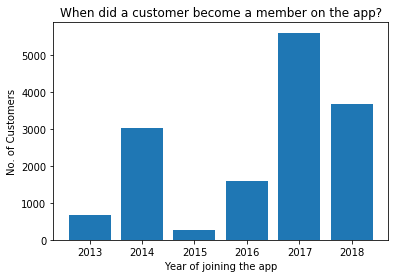

In [162]:
#When did a customer become a member on the app?
profile_year_counts = profile.member_year.value_counts()
year = profile['member_year'].unique().tolist()
data = profile_year_counts
plt.bar(year,height = data);
plt.xlabel('Year of joining the app');
plt.ylabel('No. of Customers');
plt.title('When did a customer become a member on the app?')

Text(0.5,1,'Income distribution of customer')

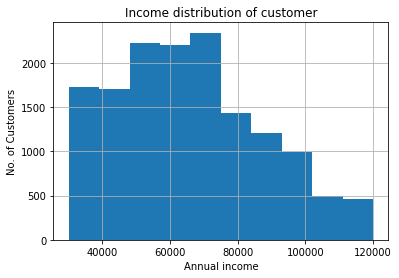

In [163]:
#Income distribution of customer
profile.income.hist();

plt.xlabel('Annual income');
plt.ylabel('No. of Customers');
plt.title('Income distribution of customer')

Text(0.5,1,'How are the customers distributed across gender?')

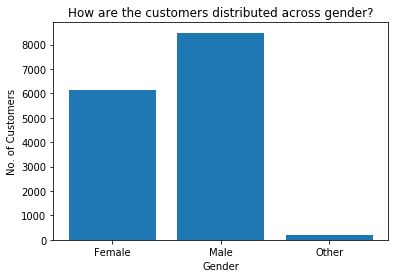

In [164]:
#How are the customers distributed across gender?
gender_dict = { 'M': 'Male','F': 'Female', 'O': 'Other'}
profile_gender_counts = profile.gender.value_counts()
gender = list(gender_dict.values())
data = profile_gender_counts
plt.bar(gender,height = data);
plt.xlabel('Gender');
plt.ylabel('No. of Customers');
plt.title('How are the customers distributed across gender?')

Text(0.5,1,'Age-wise distribution of customers')

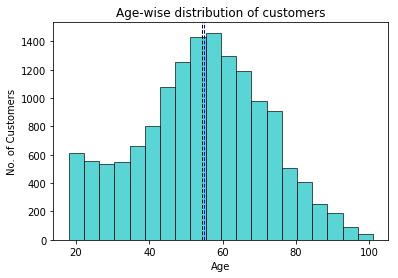

In [165]:
##Age-wise distribution of customers
result = plt.hist(profile.age, bins=20, color='c', edgecolor='k', alpha=0.65)

plt.axvline(profile.age.mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(profile.age.median(), color='b', linestyle='dashed', linewidth=1)
plt.xlabel('Age');
plt.ylabel('No. of Customers');
plt.title('Age-wise distribution of customers')

In [166]:
## Understanding How many customers took actions atleast once?
complete = transcript[transcript.event == 'offer completed']['person'].nunique()
view = transcript[transcript.event == 'offer viewed']['person'].nunique()
received = transcript[transcript.event == 'offer received']['person'].nunique()

Text(0.5,1,'How many customers took actions atleast once?')

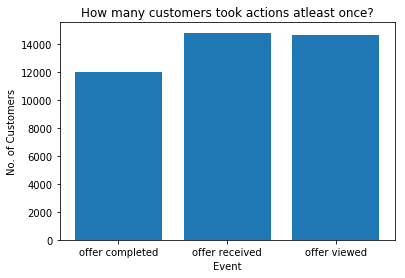

In [167]:
profile_action_counts = [received, view, complete]
action = ['offer received', 'offer viewed', 'offer completed']
data = profile_action_counts
plt.bar(action,height = data);
xlocs, xlabs = plt.xticks()
plt.xlabel('Event');
plt.ylabel('No. of Customers');
plt.title('How many customers took actions atleast once?')

In [84]:
##Divide transcations based on whether the offer was received, viewed or completed
trans_complete = transcript[transcript.event == 'offer completed']
trans_view = transcript[transcript.event == 'offer viewed']
trans_received = transcript[transcript.event == 'offer received']
trans_trans = transcript[transcript.event == 'transaction']
trans_trans = trans_trans.sort_values(by=['person_id', 'time']).reset_index(drop=True)

In [131]:
##Dataframe where offer was both viewed and completed
trans_viewncomplete = trans_received.merge(trans_view, how='inner', on=['person_id', 'offer_id']).merge(trans_complete, how='inner', on=['person_id', 'offer_id'])
trans_viewncomplete = trans_viewncomplete.drop('reward_y', axis=1)
trans_viewncomplete = trans_viewncomplete.merge(portfolio[['id','offer_id', 'offer_type', 'duration_h', 'reward', 'difficulty']], how='left', left_on='offer_id', right_on='id')
trans_viewncomplete = trans_viewncomplete[(trans_viewncomplete['time']-trans_viewncomplete['time_x'])<=trans_viewncomplete['duration_h']]
trans_viewncomplete.head()

,event_x,person_x,time_x,id_x,person_id,offer_id_x,amount_x,reward_x,event_y,person_y,...,time,id_x,amount,reward_x,id_y,offer_id_y,offer_type,duration_h,reward_y,difficulty
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,78afa995795e4d85b5d9ceeca43f5fef,2,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,...,132,78afa995795e4d85b5d9ceeca43f5fef,0,5,9b98b8c7a33c4b65b9aebfe6a799e6d9,4,bogo,168,0.5,0.25
1,offer received,78afa995795e4d85b5d9ceeca43f5fef,408,78afa995795e4d85b5d9ceeca43f5fef,2,ae264e3637204a6fb9bb56bc8210ddfd,0,0,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,...,510,78afa995795e4d85b5d9ceeca43f5fef,0,10,ae264e3637204a6fb9bb56bc8210ddfd,1,bogo,168,1.0,0.50
2,offer received,78afa995795e4d85b5d9ceeca43f5fef,504,78afa995795e4d85b5d9ceeca43f5fef,2,f19421c1d4aa40978ebb69ca19b0e20d,0,0,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,...,510,78afa995795e4d85b5d9ceeca43f5fef,0,5,f19421c1d4aa40978ebb69ca19b0e20d,9,bogo,120,0.5,0.25
3,offer received,e2127556f4f64592b11af22de27a7932,408,e2127556f4f64592b11af22de27a7932,3,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,offer viewed,e2127556f4f64592b11af22de27a7932,...,522,e2127556f4f64592b11af22de27a7932,0,5,9b98b8c7a33c4b65b9aebfe6a799e6d9,4,bogo,168,0.5,0.25
4,offer received,e2127556f4f64592b11af22de27a7932,504,e2127556f4f64592b11af22de27a7932,3,fafdcd668e3743c1bb461111dcafc2a4,0,0,offer viewed,e2127556f4f64592b11af22de27a7932,...,522,e2127556f4f64592b11af22de27a7932,0,2,fafdcd668e3743c1bb461111dcafc2a4,7,discount,240,0.2,0.50


Informational Offers

##For informational offers it is tricky to see which offers were completed. Hence, we are looking for people who received the informational offers and then made any transaction during the validity period of the offer

In [60]:
## looking at informational offers and transactions made post that
trans_received_info = trans_received.merge(trans_view, how='inner', on=['person_id', 'offer_id']).merge(portfolio[portfolio['offer_type']=='informational'], how='inner', left_on='offer_id', right_on='id')
trans_received_info_clean = trans_received_info.drop(['offer_id_x', 'id', 'amount_x', 'reward_x', 'reward_y', 'channels'], axis=1)
trans_received_info_x = trans_received_info_clean.merge(trans_trans, on='person_id', how='inner')
trans_received_info_x = trans_received_info_x[(trans_received_info_x['time_y']-trans_received_info_x['time_x'])<=trans_received_info_x['duration_h']]
info_completed = trans_received_info_x.groupby(['person_id', 'offer_id_y', 'offer_type', 'time_x'])['amount'].min().reset_index()
info_completed.head()

,person_id,offer_id_y,offer_type,time_x,amount
0,2,8,informational,168,17
1,6,8,informational,336,10
2,9,8,informational,504,0
3,11,8,informational,576,0
4,13,3,informational,408,21


Response Rates for each offer

In [61]:
##Calculating response rates
response_rate_bogo = (trans_port_satis.offer_type == 'bogo').sum()/(trans_with_port.offer_type == 'bogo').sum()
response_rate_discount = (trans_port_satis.offer_type == 'discount').sum()/(trans_with_port.offer_type == 'discount').sum()
response_rate_info = info_completed.shape[0]/(trans_with_port.offer_type == 'informational').sum()

Text(0.5,1,'Response rate for each offer type')

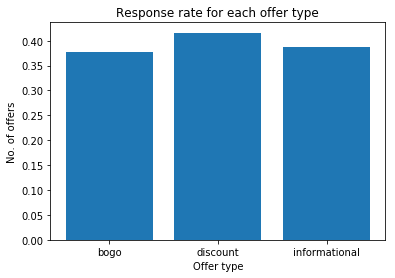

In [161]:
offer_counts = [response_rate_bogo, response_rate_discount, response_rate_info]
offers = ['bogo', 'discount', 'informational']
data = offer_counts
plt.bar(offers,height = data);
plt.xlabel('Offer type');
plt.ylabel('No. of offers');
plt.title('Response rate for each offer type')

In [62]:
trans_offers_profile = trans_port_satis[['person_id', 'offer_type']].merge(profile[['person_id', 'age_group', 'gender', 'income', 'member_year']], how='left', on='person_id')
trans_info_with_port = info_completed[['person_id', 'offer_type']].merge(profile[['person_id', 'age_group', 'gender', 'income', 'member_year']], how='left', on='person_id')

In [63]:
##Combining offers that were completed for all three offer types
completed_offers = trans_offers_profile.append(trans_info_with_port)
completed_offers.head()

,person_id,offer_type,age_group,gender,income,member_year
0,2,bogo,elderly,F,100000.0,2017
1,2,bogo,elderly,F,100000.0,2017
2,2,bogo,elderly,F,100000.0,2017
3,3,bogo,elderly,M,70000.0,2018
4,3,discount,elderly,M,70000.0,2018


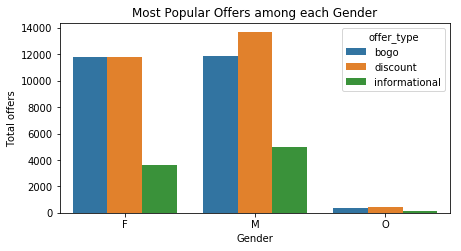

In [160]:
import seaborn as sns


plt.figure(figsize=(7, 3.5))
sns.countplot(x='gender', hue="offer_type", data= completed_offers)
plt.title('Most Popular Offers among each Gender')
plt.ylabel('Total offers')
plt.xlabel('Gender')
plt.show();

Discount offers were found to be the most popular

# Data Modeling

Create two dataframes - one with offers that were viewed and completed and the other with offer only viewed but not completed. After that, append them.

In [135]:
##Dataframe considering offers which were both viewed and completed
trans_viewcomplete = trans_viewncomplete[['person_id', 'offer_type','reward_y', 'duration_h', 'difficulty']]
trans_viewcomplete = trans_viewcomplete.merge(profile[['person_id', 'age', 'gender', 'income', 'member_year']], how='left', on='person_id')

#Since offers were completed, offer_action=1
trans_viewcomplete['offer_action'] = 1
trans_viewcomplete = trans_viewcomplete.drop(['person_id'], axis=1)
trans_viewcomplete.head()

,offer_type,reward_y,duration_h,difficulty,age,gender,income,member_year,offer_action
0,bogo,0.5,168,0.25,75,F,100000.0,2017,1
1,bogo,1.0,168,0.50,75,F,100000.0,2017,1
2,bogo,0.5,120,0.25,75,F,100000.0,2017,1
3,bogo,0.5,168,0.25,68,M,70000.0,2018,1
4,discount,0.2,240,0.50,68,M,70000.0,2018,1


In [137]:
##Dataframe considering offers which were only viewed but not completed
trans_viewonly = trans_view.merge(trans_viewncomplete, how='outer', indicator=True,  left_on=['person_id','time', 'offer_id'], right_on=['person_id','time_y', 'offer_id_x'])
trans_viewonly = trans_viewonly[trans_viewonly['_merge']=='left_only']
trans_viewonly = trans_viewonly.merge(portfolio[['id','offer_id', 'offer_type', 'duration_h', 'reward', 'difficulty']], how='left', left_on='offer_id', right_on='id')
trans_viewonly = trans_viewonly[['person_id', 'offer_type_y','reward_y', 'duration_h_y', 'difficulty_y']]
trans_viewonly = trans_viewonly.merge(profile[['person_id', 'age', 'gender', 'income', 'member_year']], how='left', on='person_id')
trans_viewonly = trans_viewonly.dropna(axis=1)

#Since offers were viewed but not completed, offer_action=0
trans_viewonly['offer_action'] = 0
trans_viewonly = trans_viewonly.drop(['person_id'], axis=1)
trans_viewonly.head()

,offer_type_y,reward_y,duration_h_y,difficulty_y,age,gender,income,member_year,offer_action
0,informational,0.0,72,0.00,75,F,100000.0,2017,0
1,discount,0.2,168,0.50,68,M,70000.0,2018,0
2,discount,0.3,168,0.35,58,M,51000.0,2017,0
3,discount,0.5,240,1.00,61,F,57000.0,2017,0
4,informational,0.0,72,0.00,61,F,57000.0,2017,0


In [145]:
#Match the names of columns in the dataframes
trans_viewonly.columns=trans_viewcomplete.columns.values

##Append the two dataframes
offer_actions = trans_viewonly.append(trans_viewcomplete)

In [148]:
offer_actions = pd.get_dummies(data=offer_actions, columns=['offer_type', 'gender'])

In [151]:
## Split into dependent and explanatory variables

X = offer_actions.drop('offer_action', axis=1)
y = offer_actions['offer_action']

## Split into test and train datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 


model = LogisticRegression()
model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_pred = model.predict_proba(X_test)
y_pred = [(a>.5).astype(int) for a in y_pred]

In [159]:
model.score(X,y)

0.7966345482474515

The above model gives us a good accuracy in predicting whether a person will complete a particular offer or not.
We can use the above model to send offers to the customers.